In [88]:
### https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression
import numpy as np
import pandas as pd 
# classifier models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
# scaler
from sklearn.preprocessing import StandardScaler
# split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# matplot libs
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt 
# to reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# scoring
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
# to classification report
from sklearn.model_selection import learning_curve
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Abaixo, funcoes de plots (ou tentativas rs) de plotar o gráfico. O último que postei era essa primeira funcao. Este comentário será apagado em 24 horas, boa noite.

In [89]:
def plotRed3d(train, point_labels, main_title='dimensionality reduction using PCA'):
    dicColors = {0:'magenta', 1:'blue'}    
    label_color = [dicColors[c] for c in point_labels]

    x_label = 'X'
    y_label = 'Y'
    z_label = 'Z'
    title = main_title 

    # creating figure
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection ="3d")

    # creating plot
    ax.scatter3D(train[:,0], train[:,1], train[:,2],c=label_color,alpha=0.8)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

    ax.legend(labels=['healthy', 'with probable ddisease'])
    plt.grid(b=True)

    plt.suptitle(title, fontsize=20)  
    # plt.savefig(title + '.png')
    plt.show()

In [90]:
import warnings
# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi
warnings.filterwarnings('ignore')

def print_val_scores(model, X_train, y_train, scoring=['f1_weighted','f1_macro','recall_weighted',
                                                       'precision_weighted'], 
                     cv=10):
    _,__,f1_w,f1_m,r,p=cross_validate(model, X_train, y_train, cv=cv,
                       scoring=scoring).items()
    mean_f1_w = f1_w[1].mean(); sd_f1_w = f1_w[1].std()
    mean_f1_m = f1_m[1].mean(); sd_f1_m = f1_m[1].std()
    mean_r = r[1].mean(); sd_r = r[1].std()
    mean_p = p[1].mean(); sd_p = p[1].std()
    
    print("Classification report for classifier {}:\nparameters:\n".format(model) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_w[0],mean_f1_w,sd_f1_w) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_m[0],mean_f1_m,sd_f1_m) +
          "{}\nmean: {}, std deviation: {}\n\n".format(r[0],mean_r,sd_r) +
          "{}\nmean: {}, std deviation: {}\n\n".format(p[0],mean_p,sd_p))

In [91]:
def print_val_custom_score (model, X_train, y_train, 
                            scoring='f1_macro', 
                            cv=10):
    print("Classification report for classifier {}:\nparameters:\n".format(model))
    
    myReturn=cross_validate(model,X_train,y_train,cv=cv,scoring=scoring)
    _,__,metric_score=myReturn
    metric_score=myReturn[metric_score]
    mean = np.mean(metric_score)
    sd = np.std(metric_score)
    print("{}\nmean: {}, std deviation: {}\n\n".format(scoring,mean,sd))

In [92]:
def print_metrics(clf, X, y, prediction):
    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y, prediction)}\n")
    disp = metrics.plot_confusion_matrix(clf, X, y)
    disp.figure_.suptitle("Confusion Matrix")

In [93]:
data=pd.read_csv('heart_pred.csv')
# data.describe()

Retirando valores nulos e NaN

In [94]:
data=data.dropna()
# data_columns=list(data.columns.values.tolist())
data=data[data.notnull()]
data=data.reset_index()
data=data.sample(frac=0.1)
data.describe()

,index,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2147.890710,0.437158,49.322404,1.950820,0.510929,9.404372,0.021858,0.002732,0.278689,0.016393,236.647541,131.459016,82.465847,26.080000,75.478142,80.489071,0.147541
std,1189.202375,0.496714,8.248861,1.013761,0.500565,12.015076,0.146420,0.052271,0.448968,0.127157,43.324628,21.735230,11.737287,4.190289,12.095434,16.874838,0.355130
min,1.000000,0.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,95.000000,52.000000,16.480000,52.000000,55.000000,0.000000
25%,1159.750000,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,207.250000,115.000000,75.000000,23.357500,67.000000,70.000000,0.000000
50%,2194.500000,0.000000,48.500000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,237.000000,129.000000,82.000000,25.730000,75.000000,77.000000,0.000000
75%,3190.500000,1.000000,55.750000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,142.000000,89.000000,28.462500,82.000000,85.000000,0.000000
max,4218.000000,1.000000,68.000000,4.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,464.000000,206.000000,119.000000,44.090000,120.000000,250.000000,1.000000


In [95]:
y=data["TenYearCHD"]
X=data.drop('TenYearCHD',axis=1)

In [96]:
# X = TSNE(n_components=2).fit_transform(X)
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [97]:
X_reduced=pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 200)

In [98]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

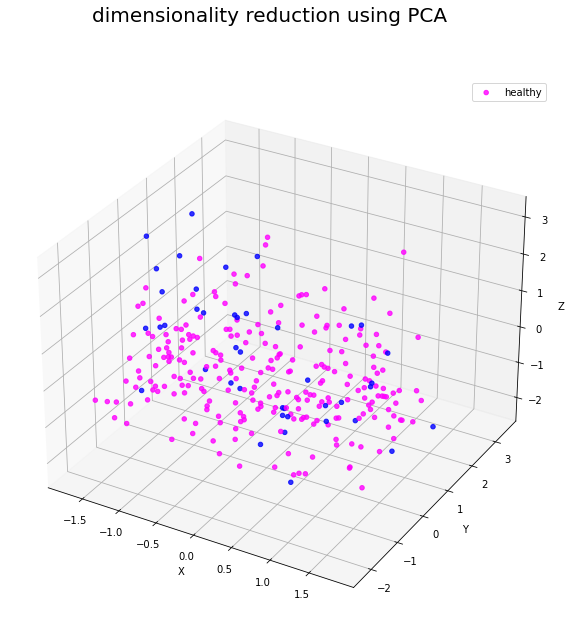

In [99]:
# print data distribution after dimentionality reduction
plotRed3d(X_train,y_train)

In [126]:
f_beta = make_scorer(fbeta_score, beta=4, average='weighted',zero_division=0)
# f_beta = make_scorer(fbeta_score, beta=2, average='weighted',zero_division=0)

In [127]:
# Criacao de grid para a Random Forest Classifier
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)

grid_rfc = {
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 11)],
    'criterion': ['gini','entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': max_depth,
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [128]:
clf_rfc = RandomForestClassifier()

In [129]:
#  Random search of parameters. Uses our shuffle selection cross validation, 
#  and search across "n_iter" different (shuffle) combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = clf_rfc, param_distributions = grid_rfc, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

rfc_search.fit(X_train, y_train)
rfc_search.best_params_

{'n_estimators': 185,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 5,
 'criterion': 'entropy',
 'bootstrap': True}

In [130]:
rfc_search.best_score_

0.8452696903029931

In [131]:
best_clf_rfc = rfc_search.best_estimator_
# print_val_scores(best_clf_rfc, X_train, y_train)

In [132]:
print_val_custom_score(best_clf_rfc, X_train, y_train,f_beta)

Classification report for classifier RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=185):
parameters:

make_scorer(fbeta_score, beta=4, average=weighted, zero_division=0)
mean: 0.8491708674255911, std deviation: 0.02438165897979618




SVM implementarion

In [133]:
clf_svm = make_pipeline(StandardScaler(), SVC())
# print(pprint(clf_svm.get_params() ))

In [134]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

C = [float(x) for x in np.linspace(start = 0.1, stop = 150.0, num = 10).astype(float)]
class_weight=['balanced', None]
kernel = ['linear', 'poly', 'rbf','sigmoid']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo','ovr']
shrinking = [True, False]

grid_svm = {'svc__C': C,
                   'svc__kernel': kernel,
                   'svc__gamma': gamma,
                   'svc__class_weight':class_weight,
                   'svc__decision_function_shape': decision_function_shape,
                   'svc__shrinking': shrinking,
                   'svc__probability': [True]
           }
# pprint(grid_svm)

In [135]:
svm_search = RandomizedSearchCV(estimator = clf_svm, param_distributions = grid_svm, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

svm_search.fit(X_train, y_train)
svm_search.best_params_

{'svc__shrinking': False,
 'svc__probability': True,
 'svc__kernel': 'rbf',
 'svc__gamma': 'auto',
 'svc__decision_function_shape': 'ovo',
 'svc__class_weight': None,
 'svc__C': 0.1}

In [136]:
best_clf_svm = svm_search.best_estimator_
svm_search.best_score_
print_val_custom_score(best_clf_svm,X_train,y_train,f_beta)

Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, decision_function_shape='ovo', gamma='auto',
                     probability=True, shrinking=False))]):
parameters:

make_scorer(fbeta_score, beta=4, average=weighted, zero_division=0)
mean: 0.8479535033263984, std deviation: 0.012155046236842581




In [112]:
#print_val_scores(best_clf_svm,X_train,y_train)

In [137]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
var_smoothing = [float(1/10**x) for x in np.linspace(start=1,stop=15,num=16)]

grid_nb = {
    'var_smoothing': var_smoothing
}
# pprint(grid_nb)

In [138]:
clf_nb = GaussianNB()
nb_search = GridSearchCV(estimator = clf_nb, param_grid = grid_nb, 
                         cv = 5, scoring=f_beta)
nb_search.fit(X_train, y_train)
nb_search.best_params_

{'var_smoothing': 0.1}

In [139]:
best_clf_nb = nb_search.best_estimator_
nb_search.best_score_
print_val_custom_score(best_clf_nb,X_train,y_train,f_beta)

Classification report for classifier GaussianNB(var_smoothing=0.1):
parameters:

make_scorer(fbeta_score, beta=4, average=weighted, zero_division=0)
mean: 0.8452591333857136, std deviation: 0.013501921129876134




In [140]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

C=[float(x) for x in np.linspace(start=0.1,stop=3,num=21)]
grid_lr = {
    'C': C,
    'n_jobs': [None, -1],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'warm_start': [False,True]
}
# pprint(grid_lr)

In [141]:
clf_lr = LogisticRegression()
# print(RandomizedSearchCV(estimator = clf_lr, param_distributions = grid_lr, n_iter=20,
#                         cv = 5, scoring=f_beta).estimator.get_params().keys())

lr_search = RandomizedSearchCV(estimator = clf_lr, param_distributions=grid_lr, 
                                 n_iter=20, cv = 5, scoring=f_beta)
lr_search.fit(X_train, y_train)
lr_search.best_params_

{'warm_start': True, 'n_jobs': -1, 'multi_class': 'ovr', 'C': 0.1}

In [142]:
best_clf_lr = lr_search.best_estimator_
lr_search.best_score_
print_val_custom_score(best_clf_lr,X_train,y_train,f_beta)

Classification report for classifier LogisticRegression(C=0.1, multi_class='ovr', n_jobs=-1, warm_start=True):
parameters:

make_scorer(fbeta_score, beta=4, average=weighted, zero_division=0)
mean: 0.8479535033263984, std deviation: 0.012155046236842581




In [143]:
clf_lr = best_clf_lr 
clf_rfc = best_clf_rfc
clf_nb = best_clf_nb
clf_svm = best_clf_svm

In [144]:
print('5 fold cross-validation')

labels = ['Logistic Regression','Random Forest Classsifier', 'Naive Bayes', 'SVM']
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm], labels):

    scores = cross_val_score(clf, X_train, y_train,
                             cv=5, scoring=f_beta)

    print("f2 Validation: %0.3f (+/- %0.3f) [%s]" % (np.mean(scores), np.std(scores), label))

5 fold cross-validation
f2 Validation: 0.848 (+/- 0.008) [Logistic Regression]
f2 Validation: 0.845 (+/- 0.013) [Random Forest Classsifier]
f2 Validation: 0.846 (+/- 0.017) [Naive Bayes]
f2 Validation: 0.848 (+/- 0.008) [SVM]


In [145]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], clf_lr),
                                                 (labels[1], clf_rfc),
                                                 (labels[2], clf_nb),
                                                 (labels[3], clf_svm)],
                                  voting='hard')

In [146]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], clf_lr),
                                                 (labels[1], clf_rfc),
                                                 (labels[2], clf_nb),
                                                 (labels[3], clf_svm)],
                                  voting='soft')

In [147]:
print('5 fold cross-validation')

labels = ['Logistic Regression','Random Forest Classifier', 'Naive Bayes', 'SVM', 
          'Voting Classifier - Hard', 'Voting Classifier - Soft']
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm, voting_clf_hard, voting_clf_soft], labels):

    scores = cross_val_score(clf, X, y,
                             cv=5, scoring=f_beta,error_score='raise')

    print("f2 Validation: %0.3f (+/- %0.3f) [%s]" % (np.mean(scores), np.std(scores), label))

5 fold cross-validation
f2 Validation: 0.836 (+/- 0.006) [Logistic Regression]
f2 Validation: 0.834 (+/- 0.007) [Random Forest Classifier]
f2 Validation: 0.844 (+/- 0.006) [Naive Bayes]
f2 Validation: 0.844 (+/- 0.006) [SVM]
f2 Validation: 0.844 (+/- 0.006) [Voting Classifier - Hard]
f2 Validation: 0.844 (+/- 0.006) [Voting Classifier - Soft]


In [148]:
print(clf_lr)
print(clf_nb)
print(clf_rfc)
print(clf_svm)

LogisticRegression(C=0.1, multi_class='ovr', n_jobs=-1, warm_start=True)
GaussianNB(var_smoothing=0.1)
RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=185)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, decision_function_shape='ovo', gamma='auto',
                     probability=True, shrinking=False))])


Classification report for classifier LogisticRegression(C=0.1, multi_class='ovr', n_jobs=-1, warm_start=True):
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        62
           1       0.00      0.00      0.00        12

    accuracy                           0.84        74
   macro avg       0.42      0.50      0.46        74
weighted avg       0.70      0.84      0.76        74


Classification report for classifier RandomForestClassifier(criterion='entropy', max_depth=5, max_features=None,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=185):
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        62
           1       0.00      0.00      0.00        12

    accuracy                           0.84        74
   macro avg       0.42      0.50      0.46        74
weighted avg       0.70      0.84      0.76        74


Classification

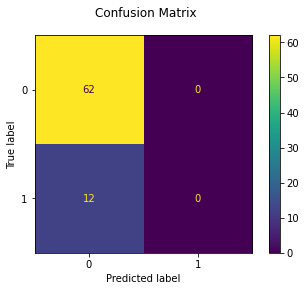

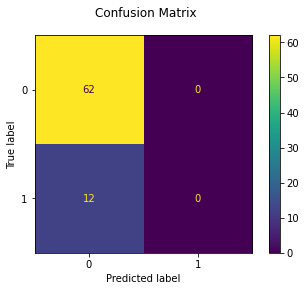

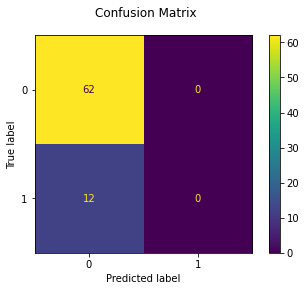

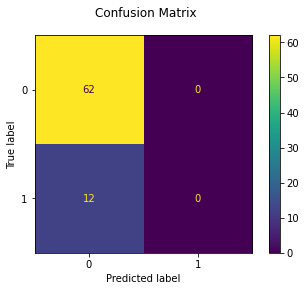

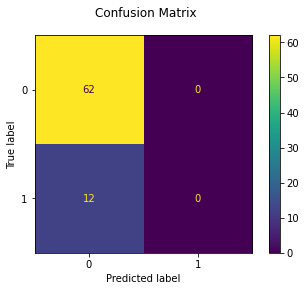

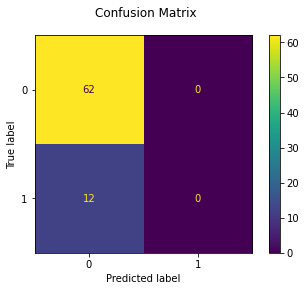

In [149]:
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm, voting_clf_hard, voting_clf_soft], labels):
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    print_metrics(clf,X_test,y_test,prediction)

Caso vc nao queira rodar tudo de novo, pode dar ctrl c+v nos grids e recuperar os melhores modelos assim:

In [79]:
# https://stackoverflow.com/questions/33110973/pass-a-dict-to-scikit-learn-estimator
grid_rfc={'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': True}

clf_rfc=RandomForestClassifier(**grid_rfc)

grid_svm={'svc__shrinking': False,
 'svc__probability': True,
 'svc__kernel': 'rbf',
 'svc__gamma': 'auto',
 'svc__decision_function_shape': 'ovo',
 'svc__class_weight': None,
 'svc__C': 0.1}

clf_svm = make_pipeline(StandardScaler(), SVC())
clf_svm.set_params(**grid_svm)

grid_nb={'var_smoothing': 0.1}
clf_nb=GaussianNB(var_smoothing= 0.1)

grid_lr={'warm_start': True, 'n_jobs': -1, 'multi_class': 'multinomial', 'C': 0.39}
clf_lr=LogisticRegression(**grid_lr)